In [1]:
from torchaudio.utils import download_asset

import torchaudio
import torch
import librosa

import numpy as np

In [2]:
import io
import os
import tarfile
import tempfile

import boto3
import matplotlib.pyplot as plt
import requests
from botocore import UNSIGNED
from botocore.config import Config
from IPython.display import Audio
from torchaudio.utils import download_asset

SAMPLE_GSM = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.gsm")
SAMPLE_WAV = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SAMPLE_WAV_8000 = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")

In [3]:
SAMPLE_WAV

'/Users/bahk_insung/.cache/torch/hub/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav'

In [4]:
url = "https://download.pytorch.org/torchaudio/tutorial-assets/steam-train-whistle-daniel_simon.wav"
with requests.get(url, stream=True) as response:
    metadata = torchaudio.info(response.raw)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchaudio/backend/sox_io_backend.py:106: UserWarning: File-like object support in sox_io backend is deprecated, and will be removed in v2.1. See https://github.com/pytorch/audio/issues/2950 for the detail.Please migrate to the new dispatcher, or use soundfile backend.
  warnings.warn(_deprecation_message)


In [5]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV)

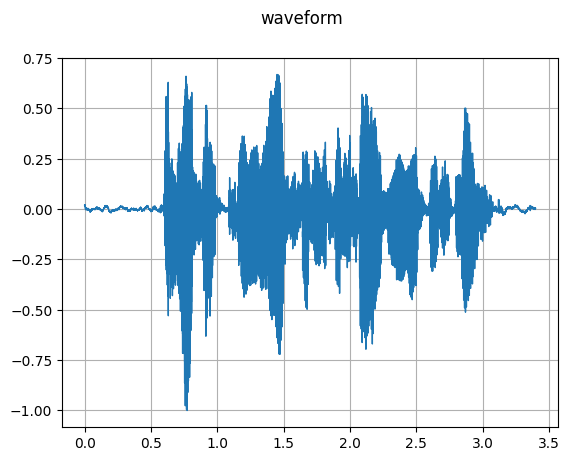

In [6]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

plot_waveform(waveform, sample_rate)

# STT Model

In [7]:
import torch
import zipfile
import torchaudio
from glob import glob

device = torch.device('cpu')  # gpu also works, but our models are fast enough for CPU

model, decoder, utils = torch.hub.load(repo_or_dir='snakers4/silero-models',
                                       model='silero_stt',
                                       language='en', # also available 'de', 'es'
                                       device=device)
(read_batch, split_into_batches,
 read_audio, prepare_model_input) = utils  # see function signature for details

# # download a single file, any format compatible with TorchAudio (soundfile backend)
# torch.hub.download_url_to_file('https://opus-codec.org/static/examples/samples/speech_orig.wav',
#                                dst ='speech_orig.wav', progress=True)
# test_files = glob('speech_orig.wav')
test_files = glob("/Users/bahk_insung/Documents/Github/ReHab-ML/experiments/배춘용.m4a")
batches = split_into_batches(test_files, batch_size=10)
input = prepare_model_input(read_batch(batches[0]),
                            device=device)

output = model(input)
for example in output:
    print(decoder(example.cpu()))

Using cache found in /Users/bahk_insung/.cache/torch/hub/snakers4_silero-models_master


In [8]:
# from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
# from datasets import load_dataset
# import soundfile as sf
# import torch
# from jiwer import wer

# processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")

# model = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean").to('cpu')

# ds = load_dataset("kresnik/zeroth_korean", "clean")

# test_ds = ds['test']

# def map_to_array(batch):
#     speech, _ = sf.read(batch["file"])
#     batch["speech"] = speech
#     return batch

# test_ds = test_ds.map(map_to_array)

# def map_to_pred(batch):
#     inputs = processor(batch["speech"], sampling_rate=16000, return_tensors="pt", padding="longest")
#     input_values = inputs.input_values.to("cpu")
    
#     with torch.no_grad():
#         logits = model(input_values).logits

#     predicted_ids = torch.argmax(logits, dim=-1)
#     transcription = processor.batch_decode(predicted_ids)
#     batch["transcription"] = transcription
#     return batch

# result = test_ds.map(map_to_pred, batched=True, batch_size=16, remove_columns=["speech"])

# print("WER:", wer(result["text"], result["transcription"]))
